In [ ]:
'''
Need to make sure you have 'fixed_review.json' using parse_jason.py 
'''

In [6]:
import pandas as pd
import numpy as np
import json
from sklearn import linear_model
import seaborn as sns
from matplotlib import pyplot as plt

In [7]:
business = pd.read_json('santa_barbara_restaurants.json')

In [8]:
#users = pd.read_json('fixed_user.json')

In [9]:
review = pd.read_json('fixed_review.json')

In [10]:
print(type(business))

<class 'pandas.core.frame.DataFrame'>


In [11]:
business.shape

(3829, 14)

In [12]:
np.zeros(18)
s = 'A'
s.lower()
b_data = business.dropna(subset=['categories'])
b_data.shape

(3828, 14)

In [13]:
# Making categories in to one hot encode {Chinese, American, Mexican, Japanese, Korean, Pizza, Burger, Sushi, Ramen, Barbeque, Restaurants, Breakfast, 
# Thai, Seafood, Steakhous, Italian, Sandwiches,  Vietnamese }

def encode_categories(attr):
    res = np.zeros(18)
    lst = attr.split(',')
    for s in lst:
        s = s.lower()
        if s == 'chinese':
            res[0] = 1
        elif s == 'american':
            res[1] = 1
        elif s == 'mexican':
            res[2] = 1
        elif s == 'japanese':
            res[3] = 1
        elif s == 'korean':
            res[4] = 1
        elif s == 'pizza':
            res[5] = 1
        elif s == 'burger':
            res[6] = 1
        elif s == 'sushi':
            res[7] = 1
        elif s == 'ramen':
            res[8] = 1
        elif s == 'barbeque':
            res[9] = 1
        elif s == 'restaurants':
            res[10] = 1
        elif s == 'breakfast':
            res[11] = 1
        elif s == 'thai':
            res[12] = 1
        elif s == 'seafood':
            res[13] = 1
        elif s == 'steakhous':
            res[14] = 1
        elif s == 'italian':
            res[15] = 1
        elif s == 'sandwiches':
            res[16] = 1
        elif s == 'vietnamese':
            res[17] = 1
        return res


In [14]:
b_data['categories'] = b_data['categories'].apply(encode_categories)

/tmp/ipykernel_15878/894832119.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b_data['categories'] = b_data['categories'].apply(encode_categories)


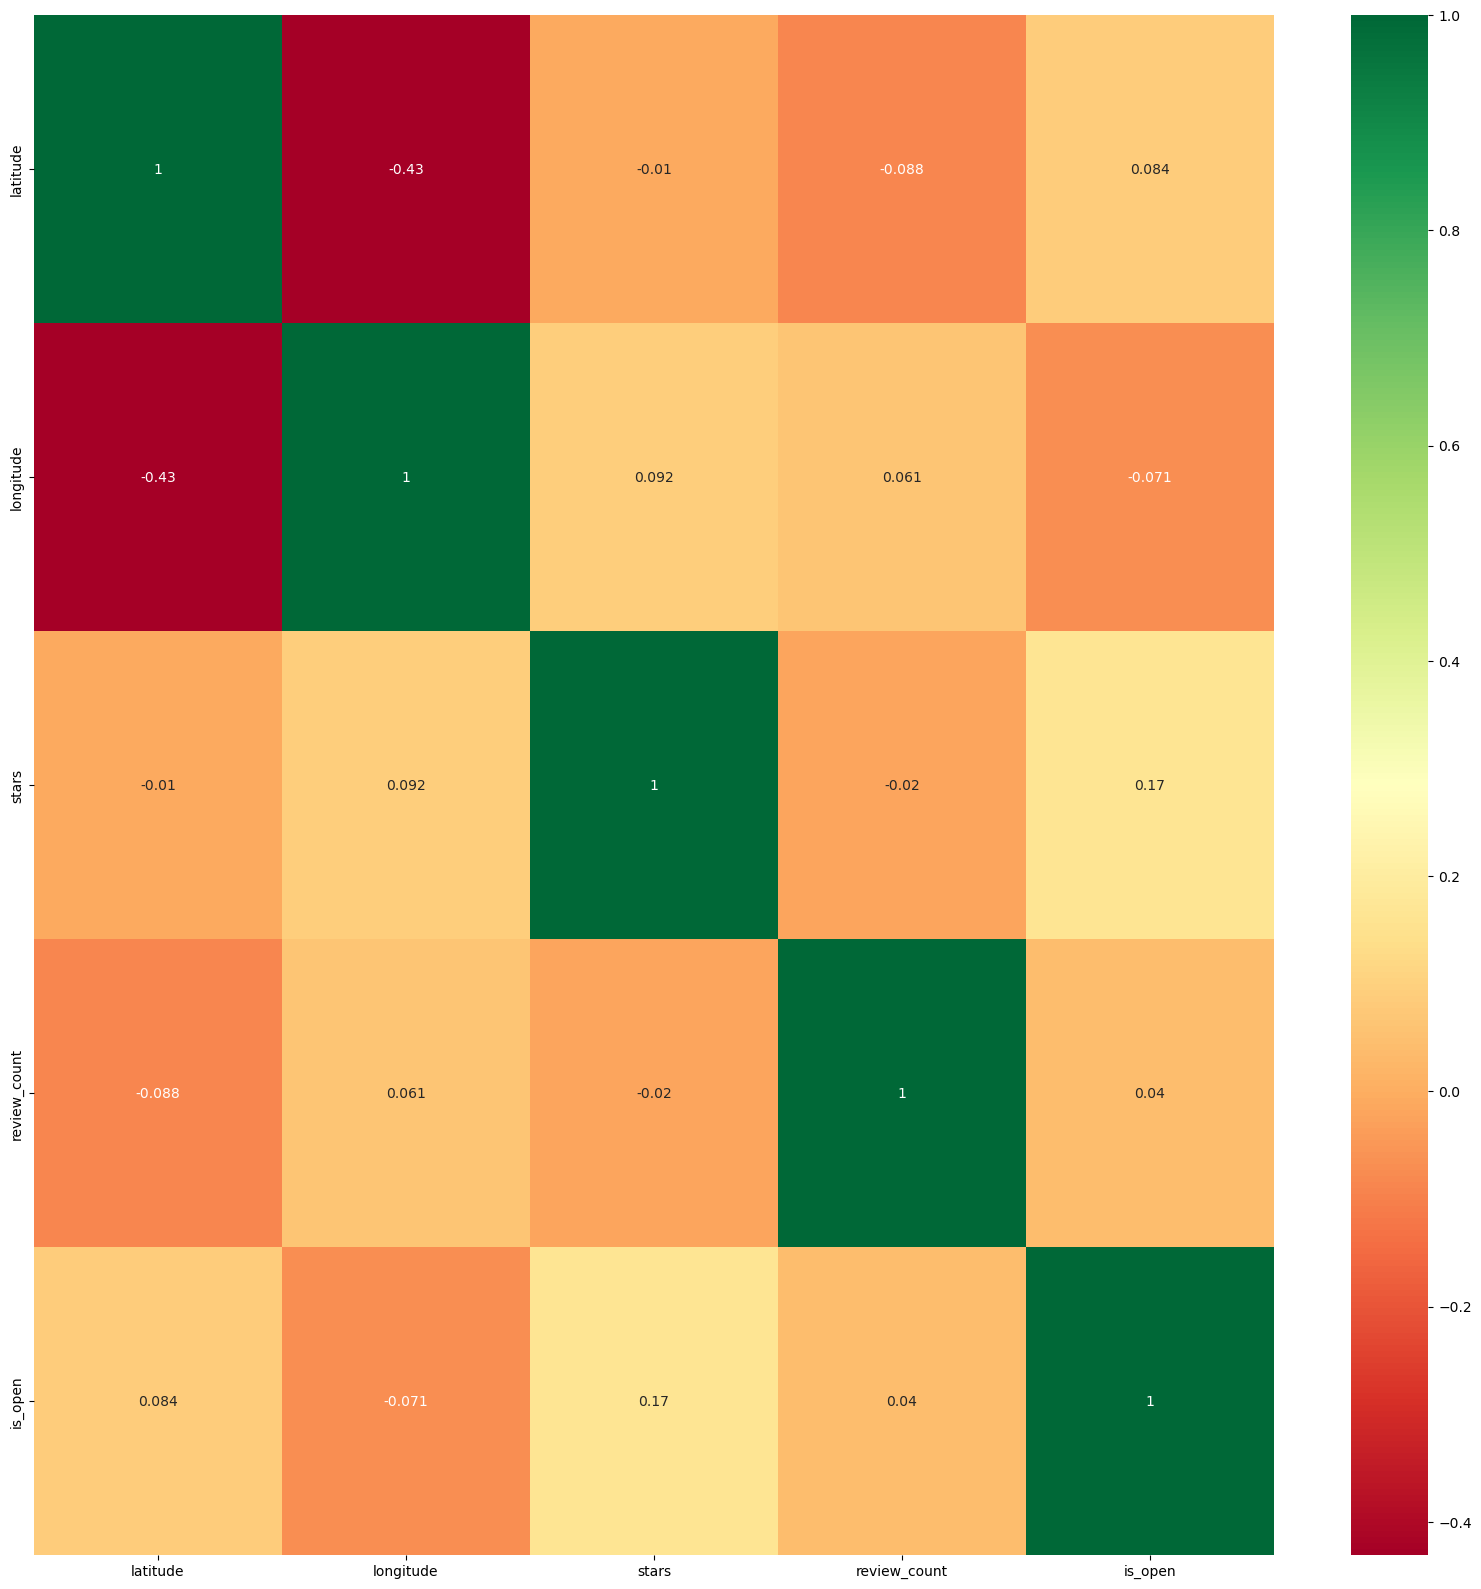

In [15]:
features = b_data.drop(columns=['business_id', 'name', 'address', 'city', 'state', 'attributes', 'postal_code', 'categories', 'hours'])
corrmat = features.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20, 20))
g = sns.heatmap(features[top_corr_features].corr(), annot=True, cmap='RdYlGn')

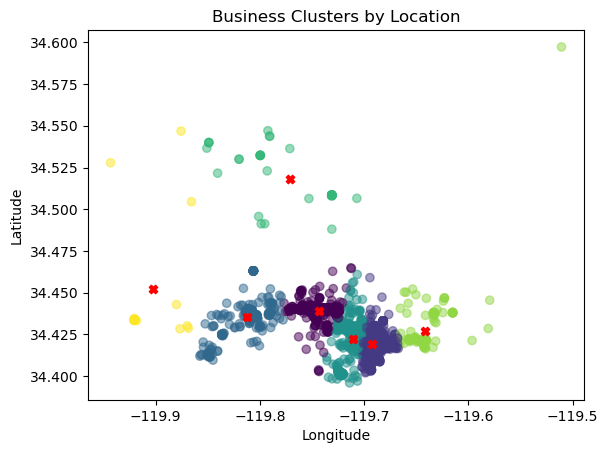

Preview of Clustered Data:
                          name   latitude   longitude  cluster_id
0     Abby Rappoport, LAC, CMQ  34.426679 -119.711197           3
1                          H&M  34.420209 -119.700460           1
2         Helena Avenue Bakery  34.414445 -119.690672           1
3         Iron Horse Auto Body  34.419620 -119.677032           1
4  Tinkle Belle Diaper Service  34.420334 -119.710749           3


In [36]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

#Load data
file_path = 'santa_barbara_restaurants.json' 
with open(file_path, 'r') as file:
    data = json.load(file)  

df = pd.DataFrame(data)

# Handle Missing Values
# Drop rows with missing critical fields: latitude, longitude, categories
df = df.dropna(subset=['latitude', 'longitude', 'categories'])

# Normalize star and review count
scaler = MinMaxScaler()
df[['stars', 'review_count']] = scaler.fit_transform(df[['stars', 'review_count']])

#One-Hot Encode 'categories'
df = pd.concat(
    [df, df['categories'].str.get_dummies(sep=', ')],
    axis=1
)

# Prepare latitude and longitude for clustering
coordinates = df[['longitude', 'latitude']].to_numpy()

# use liberies for kmeans and cluster
kmeans = KMeans(n_clusters=7, random_state=42)
cluster_ids = kmeans.fit_predict(coordinates)
df['cluster_id'] = cluster_ids

# plot
plt.scatter(df['longitude'], df['latitude'], c=cluster_ids, cmap='viridis', alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X')
plt.title('Business Clusters by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


print("Preview of Clustered Data:")
print(df[['name', 'latitude', 'longitude', 'cluster_id']].head())

In [38]:
# Recommend top restrurant in a cluster

from sklearn.metrics import pairwise_distances

# Load data
file_path = 'clustered_yelp_data.json'  # Replace with your file path
df = pd.read_json(file_path, lines=True)

# Recommendation Function
def recommend_top_restaurants(cluster_data, top_n=10):
    """
    Recommends top restaurants within a cluster based on stars and review_count.
    """
    cluster_data = cluster_data.copy()  # Avoid SettingWithCopyWarning
    cluster_data.loc[:, 'weighted_score'] = cluster_data['stars'] * cluster_data['review_count']
    top_restaurants = cluster_data.nlargest(top_n, 'weighted_score')
    return top_restaurants[['name', 'stars', 'review_count', 'categories']]

# Group data by clusters and recommend
recommendations = {}
for cluster_id in df['cluster_id'].unique():
    cluster_data = df[df['cluster_id'] == cluster_id]
    recommendations[str(cluster_id)] = recommend_top_restaurants(cluster_data).to_dict(orient='records')

# collaborative filtering and similarity based recommendations
def jaccard_similarity(categories_a, categories_b):
    """
    Computes the Jaccard similarity between two category lists.
    """
    set_a = set(categories_a.split(', '))
    set_b = set(categories_b.split(', '))
    intersection = len(set_a & set_b)
    union = len(set_a | set_b)
    return intersection / union if union > 0 else 0

def collaborative_filtering(cluster_data, target_business, top_n=10):
    """
    Recommend similar businesses within a cluster using Jaccard similarity.
    """
    cluster_data = cluster_data.copy()  # Avoid SettingWithCopyWarning
    target_categories = target_business['categories']
    similarities = cluster_data.apply(
        lambda x: jaccard_similarity(target_categories, x['categories']), axis=1
    )
    cluster_data.loc[:, 'similarity'] = similarities
    similar_businesses = cluster_data.nlargest(top_n, 'similarity')
    return similar_businesses[['name', 'similarity', 'stars', 'review_count', 'categories']]

# Example collaborative filtering for a target business

cluster_id = 0  # Replace with desired cluster ID
target_business = df[df['cluster_id'] == cluster_id].iloc[0]  # First business in the cluster
similar_businesses = collaborative_filtering(df[df['cluster_id'] == cluster_id], target_business)

# display
print(f"Top Recommendations for Cluster {cluster_id}:")
print(recommendations[str(cluster_id)])

print("\nCollaborative Filtering Results:")
print(similar_businesses)


Top Recommendations for Cluster 0:
[{'name': "Boathouse at Hendry's Beach", 'stars': 0.75, 'review_count': 0.6610080961, 'categories': 'Seafood, Restaurants, Hawaiian, American (New), Breakfast & Brunch'}, {'name': 'Lure Fish House', 'stars': 0.875, 'review_count': 0.3781666231, 'categories': 'Breakfast & Brunch, Food, Beer, Wine & Spirits, Bars, Seafood, Restaurants, Wine Bars, Cocktail Bars, American (New), Nightlife'}, {'name': 'Los Agaves', 'stars': 0.75, 'review_count': 0.20945416560000002, 'categories': 'American (New), Mexican, Restaurants'}, {'name': 'Via Maestra 42', 'stars': 0.875, 'review_count': 0.1525202403, 'categories': 'Caterers, Italian, Restaurants, Delis, Event Planning & Services'}, {'name': "Renaud's Patisserie & Bistro", 'stars': 0.875, 'review_count': 0.1355445286, 'categories': 'French, Cafes, Restaurants, Breakfast & Brunch, Food, Sandwiches, Bakeries'}, {'name': "Jeannine's American Bakery Restaurant", 'stars': 0.75, 'review_count': 0.1488639331, 'categories':

In [40]:
# What we can use to calculate the how well we do


from sklearn.metrics import mean_squared_error, precision_score

# Define Metrics for Evaluation

def calculate_mse(true_ratings, predicted_ratings):
    """
    Calculate Mean Squared Error (MSE) for rating predictions.
    """
    return mean_squared_error(true_ratings, predicted_ratings)

def calculate_precision_at_k(true_items, recommended_items, k=10):
    """
    Calculate Precision@k for recommendation evaluation.
    """
    true_items_set = set(true_items)
    recommended_items_set = set(recommended_items[:k])
    relevant_items = true_items_set & recommended_items_set
    return len(relevant_items) / k

In [41]:
# Given a user id or a business id then recommend top similarity retaurants

from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity


# merge review and business data
merged_df = review.merge(
    business[['business_id', 'name', 'categories']],
    on='business_id',
    how='left'
)

# handle unmatched business ids
merged_df['name'] = merged_df['name'].fillna('Unknown Business')
merged_df['categories'] = merged_df['categories'].fillna('Unknown Categories')

# encode user and business ids with lib
merged_df['user_id_encoded'] = merged_df['user_id'].astype('category').cat.codes
merged_df['business_id_encoded'] = merged_df['business_id'].astype('category').cat.codes

# Create mappings for ID decoding
user_id_map = dict(enumerate(merged_df['user_id'].astype('category').cat.categories))
business_id_map = dict(enumerate(merged_df['business_id'].astype('category').cat.categories))

# Create sparse interaction matrix
interaction_matrix_sparse = csr_matrix(
    (merged_df['stars'], (merged_df['user_id_encoded'], merged_df['business_id_encoded']))
)

# User collaborative filtering
def recommend_for_user_sparse(user_id, interaction_matrix_sparse, user_id_map, business_id_map, business_df, top_n=5):
    """
    Recommend businesses for a user using sparse matrix for user-based collaborative filtering.
    Returns both the business names and IDs.
    """
    # get user index
    user_idx = {v: k for k, v in user_id_map.items()}.get(user_id)
    if user_idx is None:
        raise KeyError(f"User {user_id} not found in the dataset.")
    
    # compute user similarity
    user_similarity = cosine_similarity(interaction_matrix_sparse[user_idx], interaction_matrix_sparse).flatten()
    
    # predict ratings for all businesses
    predicted_ratings = interaction_matrix_sparse.T.dot(user_similarity) / (np.abs(user_similarity).sum() + 1e-10)
    
    # Exclude already rated businesses
    user_rated = interaction_matrix_sparse[user_idx].toarray().flatten() > 0
    predicted_ratings[user_rated] = -np.inf  # Mark already rated businesses as not recommendable
    
    # Recommend top N unrated businesses
    top_businesses = predicted_ratings.argsort()[-top_n:][::-1]
    business_ids = [business_id_map[idx] for idx in top_businesses]
    
    # Retrieve business names and IDs
    recommendations = business_df[business_df['business_id'].isin(business_ids)][['business_id', 'name']]
    return recommendations


# Item Collaborative Filtering
def recommend_similar_items(business_id, interaction_matrix_sparse, user_id_map, business_id_map, business_df, top_n=5):
    """
    Recommend similar businesses using sparse matrix for item-based collaborative filtering.
    Returns both the business names and IDs.
    """
    # Get business index
    business_idx = {v: k for k, v in business_id_map.items()}.get(business_id)
    if business_idx is None:
        raise KeyError(f"Business {business_id} not found in the dataset.")
    
    # Compute item similarity
    item_similarity = cosine_similarity(interaction_matrix_sparse.T[business_idx], interaction_matrix_sparse.T).flatten()
    
    # Recommend top N similar businesses
    top_businesses = item_similarity.argsort()[-(top_n + 1):][::-1]  # Include business itself
    business_ids = [business_id_map[idx] for idx in top_businesses if idx != business_idx][:top_n]  # Exclude the business itself
    
    # Retrieve business names and IDs
    recommendations = business_df[business_df['business_id'].isin(business_ids)][['business_id', 'name']]
    return recommendations


example_user_id = 'qVc8ODYU5SZjKXVBgXdI7w' # Replace with a user id
example_business_id = 'Pns2l4eNsfO8kk83dixA6A' # Replace with a business id

try:
    user_recommendations = recommend_for_user_sparse(
        example_user_id,
        interaction_matrix_sparse,
        user_id_map,
        business_id_map,
        business,
        top_n=5
    )
    print("Recommended businesses for user:")
    print(user_recommendations)
except KeyError as e:
    print(e)

# Example 
try:
    item_recommendations = recommend_similar_items(
        example_business_id,
        interaction_matrix_sparse,
        user_id_map,
        business_id_map,
        business,
        top_n=5
    )
    print("Recommended similar businesses:")
    print(item_recommendations)
except KeyError as e:
    print(e)


Recommended businesses for user:
                business_id                             name
5    SZU9c8V2GuREDN5KgyHFJw  Santa Barbara Shellfish Company
225  wFES5bGDiPANW13hNHnXOQ      Sakana Sushi Bar & Japanese
Recommended similar businesses:
Empty DataFrame
Columns: [business_id, name]
Index: []
